In [28]:
import IPython

def display_code(code):
    def _jupyterlab_repr_html_(self):
        from pygments import highlight
        from pygments.formatters import HtmlFormatter

        fmt = HtmlFormatter()
        style = "<style>{}\n{}</style>".format(
            fmt.get_style_defs(".output_html"), fmt.get_style_defs(".jp-RenderedHTML")
        )
        return style + highlight(self.data, self._get_lexer(), fmt)

    # Replace _repr_html_ with our own version that adds the 'jp-RenderedHTML' class
    # in addition to 'output_html'.
    IPython.display.Code._repr_html_ = _jupyterlab_repr_html_
    return IPython.display.Code(data=code, language="python3")

def display_for_code():
    def _jupyterlab_repr_html_(self):
        from pygments import highlight
        from pygments.formatters import HtmlFormatter

        fmt = HtmlFormatter()
        style = "<style>{}\n{}</style>".format(
            fmt.get_style_defs(".output_html"), fmt.get_style_defs(".jp-RenderedHTML")
        )
        return style + highlight(self.data, self._get_lexer(), fmt)

    # Replace _repr_html_ with our own version that adds the 'jp-RenderedHTML' class
    # in addition to 'output_html'.
    IPython.display.Code._repr_html_ = _jupyterlab_repr_html_
    return IPython.display.Code

Enterprises often have multiple data scientists working on the similar data, and their code is usually checked into a central repository such as GitHub.  SemForms mines such a repository of code manipulating various datasets to mine what other data scientists have done with similar datasets.  In particular, this demo notebook illustrates how SemForms can generate code which help with cleansing a dataset for downstream tasks such as model building or analysis.

As an example, let us assume that a data scientist wants to clean the Kaggle titanic survival prediction dataset.

In [29]:
import pandas
df = pandas.read_csv('/data/semforms-steam/graph4code/data/titanic_train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Notice that this dataset like many others has many issues - it needs to be cleansed in order for it to be useful.   We have columns that are categorical (e.g. Embarked), columns that do not seem very relevant (e.g., Ticket, Name).  Now lets try and ask SEMFORMs to ask for code recommendations on cleaning up this dataset.

In [30]:
import requests
import json
cols = list(df.columns)
dataset_desc = {'dataset': 'titanic', 'columns':cols}
response = requests.post('http://expressions2.sl.cloud9.ibm.com:6660/expressions', json=dataset_desc)
data = response.json()

In [31]:
import logging

def bad_function(fn_name, function, df):
    try:
        new_df = df.copy()
        d = {}
        exec(function, d)
        f = d[fn_name]
        f(new_df)
        if new_df.equals(df):
            return True
    except Exception as exc:
        #logging.exception("Eval failed")
        return True
 
    return False

def make_func(function, code_lines, add_func_def=True):
    buf = '\n\t'.join(code_lines)
    if add_func_def:
        return 'def ' + function + '(df):' + '\n\t' + buf
    return buf

def add_imports():
    buf = ['import pandas', 'import numpy', 'import seaborn', 'import matplotlib', 'import sklearn.preprocessing']
    return '\n'.join(buf) + '\n'

def add_new_data(new_data, col, script, function, fn):
    if col not in new_data:
        new_data[col] = {}
    if script not in new_data[col]:
        new_data[col][script] = {}
    if function not in new_data[col][script]:
        new_data[col][script][function] = fn

def process_data(data, df):
    functions2code = {}
    functions2codelines = {}
    new_data = {}
    # process dependencies after the functions without dependencies
    for col in data:
        for script in data[col]:
            for function in data[col][script]:
                if 'dependencies' in data[col][script][function]:
                    continue
                functions2codelines[function] = data[col][script][function]['code']
                fn = add_imports() + make_func(function, data[col][script][function]['code'])
                if not bad_function(function, fn, df):
                    functions2code[function] = fn
                    func = make_func(function, data[col][script][function]['code'])
                    add_new_data(new_data, col, script, function, func)
    
    # process dependencies now, filtering dependencies that are not in functions2code
    for col in data:
        for script in data[col]:
            for function in data[col][script]:
                if 'dependencies' in data[col][script][function]:
                    new_deps = []
                    new_deps_str = []
                    
                    for dep in data[col][script][function]['dependencies']:
                        if dep in functions2code:
                            new_deps_str.append(dep + '(df)')
                            new_deps.append(dep)
                    
                    buf = '\n\t'.join(new_deps_str)  
                    
                    fn = ''
                    for dep in new_deps:
                        fn += make_func(dep, functions2codelines[dep]) + '\n'
                    fn += 'def ' + function + '(df):\n\t' + buf + '\n\t' + make_func(function, data[col][script][function]['code'], False)
                    if not bad_function(function, add_imports() + fn, df):
                        functions2code[function] = fn
                        add_new_data(new_data, col, script, function, fn)

    return new_data, functions2code
 

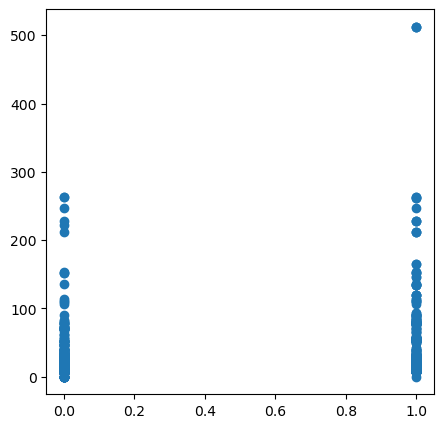

In [32]:
new_data, functions2code = process_data(data, df)


SEMFORMs returns a list of functions, organized by script and the field that they operate on.  For operations that create new features from multiple columns, the system will return a single function that may depend on other cleansing functions.  Choosing a specific function will copy the code into the notebook.

In [33]:
import ipywidgets as widgets

cols = list(new_data.keys())

columns = widgets.Dropdown(
        options=cols,
        value=cols[0],
        description='Columns:',
        disabled=False,
    )

display(columns) 
dh = IPython.display.display(display_id=True)
dc = display_for_code()

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        col = columns.value
        scripts = list(new_data[col].keys())
        buf = []
        for script in scripts:
            buf.append('# from script:' + script + '\n')
            script_fns = []
            deps = []
            for function in new_data[col][script]:
                 buf.append(new_data[col][script][function])
        fun = add_imports() + '\n'.join(buf) + '\n'
        dh.update(dc(data=fun, language="python3"))

columns.observe(on_change)


Dropdown(description='Columns:', options=('Embarked', 'SibSp', 'Age', 'Name', 'Fare', 'all'), value='Embarked'…

import pandas
import numpy
import seaborn
import matplotlib
import sklearn.preprocessing
# from script:https://github.com/davified/clean-code-ml/blob/master/notebooks/titanic-original.ipynb

def Age_4(df):
	df.loc[(df[ 'Age' ] <= 16), 'Age'] = 0
	df.loc[((df[ 'Age' ] > 48) & (df[ 'Age' ] <= 64)), 'Age'] = 3
	df.loc[((df[ 'Age' ] > 16) & (df[ 'Age' ] <= 32)), 'Age'] = 1
	df.loc[((df[ 'Age' ] > 32) & (df[ 'Age' ] <= 48)), 'Age'] = 2
def Age_3(df):
	df[ 'AgeBand' ] = pandas.cut(df[ 'Age' ], 5)
def all_1(df):
	Age_4(df)
	Age_3(df)
	df[ 'Age*Class' ] = (df[ 'Age' ] * df[ 'Pclass' ])

In [34]:
import pandas
df = pandas.read_csv('/data/semforms-steam/graph4code/data/heart_disease_uci.csv')
df

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,917,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2
918,919,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


In [35]:
import requests
import json
cols = list(df.columns)
dataset_desc = {'dataset': 'heart', 'columns':cols}
response = requests.post('http://expressions2.sl.cloud9.ibm.com:6660/expressions', json=dataset_desc)
h_data = response.json()

{'exang': {'https://www.kaggle.com/code/morenovanton/heart-disease-anova-interaction-of-variables/notebook': {'exang_1': {'code': ['df[ \'exang\' ] = df[ \'exang\' ].map(["no","yes"])']}, 'exang_2': {'code': ['df[ \'exang\' ] = df[ \'exang\' ].map({"no":0,"yes":1})']}}, 'https://www.kaggle.com/code/achintyak/decision-tree': {'exang_0': {'code': ['df[ \'exang\' ] = df[ \'exang\' ].fillna("False")']}}}, 'sex': {'https://www.kaggle.com/code/morenovanton/heart-disease-anova-interaction-of-variables/notebook': {'sex_1': {'code': ['df[ \'sex\' ] = df[ \'sex\' ].map(["female","male"])']}, 'sex_2': {'code': ['df[ \'sex\' ] = df[ \'sex\' ].map({"female":0,"male":1})']}}, 'https://www.kaggle.com/code/achintyak/decision-tree': {'sex_0': {'code': ["df[ 'sex_n' ] = sklearn.preprocessing.LabelEncoder.LabelEncoder().fit_transform(df[ 'sex' ])"]}}}, 'num': {'https://www.kaggle.com/code/achintyak/decision-tree': {'num_0': {'code': ["df.loc[(df[ 'num' ] == 2), 'num'] = 1", "df.loc[(df[ 'num' ] == 4), 'n

In [26]:
heart_data, heart_functions2code = process_data(h_data, df)

In [27]:
import ipywidgets as widgets

cols = list(heart_data.keys())

columns = widgets.Dropdown(
        options=cols,
        value=cols[0],
        description='Columns:',
        disabled=False,
    )

display(columns) 
dh = IPython.display.display(display_id=True)
dc = display_for_code()

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        col = columns.value
        scripts = list(heart_data[col].keys())
        buf = []
        for script in scripts:
            buf.append('# from script:' + script + '\n')
            script_fns = []
            deps = []
            for function in heart_data[col][script]:
                 buf.append(heart_data[col][script][function])
        fun = add_imports() + '\n'.join(buf) + '\n'
        dh.update(dc(data=fun, language="python3"))

columns.observe(on_change)

Dropdown(description='Columns:', options=('exang', 'sex', 'num', 'thal', 'chol', 'slope', 'trestbps', 'oldpeak…

import pandas
import numpy
import seaborn
import matplotlib
import sklearn.preprocessing
# from script:https://www.kaggle.com/code/achintyak/decision-tree

def restecg_0(df):
	df[ 'restecg' ] = df[ 'restecg' ].fillna("normal")